In [515]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [516]:
gen1_train = pd.read_csv("gen1_train_comp_final.csv")
gen2_train = pd.read_csv("gen2_train_comp_final.csv")
gen1_test = pd.read_csv("gen1_test_comp_final.csv")
gen2_test = pd.read_csv("gen2_test_upto9_comp_final.csv")

In [517]:
gen1_train.head()

,gen1_id,sex_assigned_at_birth,age,SHgt_cm
0,774,F,0.10,56.961812
1,774,F,0.25,64.826190
2,774,F,0.50,74.340764
3,774,F,0.75,79.747338
4,774,F,1.00,84.092569


In [518]:
gen1_test.head()

,gen1_id,sex_assigned_at_birth,age,SHgt_cm
0,768,F,0.10,53.822825
1,768,F,0.25,61.455579
2,768,F,0.50,69.757527
3,768,F,0.75,73.385477
4,768,F,1.00,78.129137


In [519]:
gen2_train.head()

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg
0,3012,M,mother,636,0.10,56.251625,4.636903
1,3012,M,mother,636,0.25,64.491579,NaN
2,3012,M,mother,636,0.50,70.465927,NaN
3,3012,M,mother,636,0.75,73.992677,NaN
4,3012,M,mother,636,1.00,79.343537,NaN


In [520]:
gen2_test.head()

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg
0,2831,F,mother,455,0.10,52.912025,NaN
1,2831,F,mother,455,0.25,59.532779,NaN
2,2831,F,mother,455,0.50,67.733527,NaN
3,2831,F,mother,455,0.75,70.450677,NaN
4,2831,F,mother,455,1.00,74.991937,NaN


In [521]:
gen2_test.isna().sum()

gen2_id                    0
sex_assigned_at_birth      0
study_parent_sex           0
study_parent_id_new        0
AgeGr                      0
SHgt_cm                  132
Wgt_kg                   823
dtype: int64

In [522]:
# Imputing height and weight with linear interpolation
gen1_train['SHgt_cm'] = gen1_train.groupby('gen1_id')['SHgt_cm'].transform(lambda x: x.interpolate(method='linear'))
gen1_test['SHgt_cm'] = gen1_test.groupby('gen1_id')['SHgt_cm'].transform(lambda x: x.interpolate(method='linear'))

gen2_train['SHgt_cm'] = gen2_train.groupby('gen2_id')['SHgt_cm'].transform(lambda x: x.interpolate(method='linear'))
gen2_test['SHgt_cm'] = gen2_test.groupby('gen2_id')['SHgt_cm'].transform(lambda x: x.interpolate(method='linear'))

gen2_train['Wgt_kg'] = gen2_train.groupby('gen2_id')['Wgt_kg'].transform(lambda x: x.interpolate(method='linear'))
gen2_test['Wgt_kg'] = gen2_test.groupby('gen2_id')['Wgt_kg'].transform(lambda x: x.interpolate(method='linear'))

In [523]:
# Imputing height  and weight with mean of same sex and age for remaining missing values
gen1_train['SHgt_cm'] = gen1_train.groupby(['sex_assigned_at_birth', 'age'])['SHgt_cm'].transform(lambda x: x.fillna(x.mean()))
gen1_test['SHgt_cm'] = gen1_test.groupby(['sex_assigned_at_birth', 'age'])['SHgt_cm'].transform(lambda x: x.fillna(x.mean()))

gen2_train['SHgt_cm'] = gen2_train.groupby(['sex_assigned_at_birth', 'AgeGr'])['SHgt_cm'].transform(lambda x: x.fillna(x.mean()))
gen2_test['SHgt_cm'] = gen2_test.groupby(['sex_assigned_at_birth', 'AgeGr'])['SHgt_cm'].transform(lambda x: x.fillna(x.mean()))

gen2_train['Wgt_kg'] = gen2_train.groupby(['sex_assigned_at_birth', 'AgeGr'])['Wgt_kg'].transform(lambda x: x.fillna(x.mean()))
gen2_test['Wgt_kg'] = gen2_test.groupby(['sex_assigned_at_birth', 'AgeGr'])['Wgt_kg'].transform(lambda x: x.fillna(x.mean()))


In [524]:
gen2_train.isna().sum()

gen2_id                    0
sex_assigned_at_birth      0
study_parent_sex           0
study_parent_id_new        0
AgeGr                      0
SHgt_cm                    0
Wgt_kg                   864
dtype: int64

In [525]:
# Merge parent and children training sets (dropping weight for now) and using inner join

merged_train = gen2_train.merge(gen1_train, how='inner', left_on=['study_parent_id_new','AgeGr'], right_on=['gen1_id', 'age'])

merged_train = merged_train.drop(['study_parent_sex', 'study_parent_id_new', 'Wgt_kg'], axis=1)

merged_train = merged_train.rename({'gen1_id':'parent_id', 'sex_assigned_at_birth_x':'child_sex', 
                     'age':'parent_age', 'SHgt_cm_x':'child_height', 'gen2_id':'child_id',
                     'sex_assigned_at_birth_y':'parent_sex', 'AgeGr':'child_age', 
                     'SHgt_cm_y':'parent_height'}, axis=1)

merged_train.head()

,child_id,child_sex,child_age,child_height,parent_id,parent_sex,parent_age,parent_height
0,3012,M,0.10,56.251625,636,M,0.10,53.818812
1,3012,M,0.25,64.491579,636,M,0.25,61.276841
2,3012,M,0.50,70.465927,636,M,0.50,68.828343
3,3012,M,0.75,73.992677,636,M,0.75,75.452930
4,3012,M,1.00,79.343537,636,M,1.00,77.834870


In [526]:
# Merge parent and children test sets (dropping weight for now)

merged_test = gen2_test.merge(gen1_test, how='left', left_on=['study_parent_id_new','AgeGr'], right_on=['gen1_id', 'age'])

merged_test = merged_test.drop(['study_parent_sex', 'study_parent_id_new', 'Wgt_kg'], axis=1)

merged_test = merged_test.rename({'gen1_id':'parent_id', 'sex_assigned_at_birth_x':'child_sex', 
                     'age':'parent_age', 'SHgt_cm_x':'child_height', 'gen2_id':'child_id',
                     'sex_assigned_at_birth_y':'parent_sex', 'AgeGr':'child_age', 
                     'SHgt_cm_y':'parent_height'}, axis=1)

merged_test.head()

,child_id,child_sex,child_age,child_height,parent_id,parent_sex,parent_age,parent_height
0,2831,F,0.10,52.912025,NaN,NaN,NaN,NaN
1,2831,F,0.25,59.532779,NaN,NaN,NaN,NaN
2,2831,F,0.50,67.733527,NaN,NaN,NaN,NaN
3,2831,F,0.75,70.450677,NaN,NaN,NaN,NaN
4,2831,F,1.00,74.991937,NaN,NaN,NaN,NaN


In [527]:
le = LabelEncoder()
columns_to_encode = ['parent_sex', 'child_sex']

for col in columns_to_encode:
    merged_train[col] = le.fit_transform(merged_train[col])
    merged_test[col] = le.fit_transform(merged_test[col])

In [528]:
X_train = (
    merged_train[merged_train["child_age"] <= 9]
    .pivot(index="child_id", columns="child_age", values="child_height")
)

# Rename columns to reflect age-based features
X_train.columns = [f"height_at_age_{age}" for age in X_train.columns]

# Add parent-related features (aggregated)
parent_features = merged_train.groupby("child_id").agg(
    parent_max_height=("parent_height", "max"),
    parent_min_height=("parent_height", "min"),
    parent_mean_height=("parent_height", "mean"),
    parent_growth_slope=("parent_height", lambda x: (x.iloc[-1] - x.iloc[0]) / (x.index[-1] - x.index[0] + 1))
)
X_train = X_train.merge(parent_features, left_index=True, right_index=True)


In [529]:
y_train = (
    merged_train[merged_train["child_age"] > 9]
    .pivot(index="child_id", columns="child_age", values="child_height")
)

# Rename target columns
y_train.columns = [f"target_height_at_age_{int(age)}" for age in y_train.columns]


In [530]:
X_train.head()

,height_at_age_0.1,height_at_age_0.25,height_at_age_0.5,height_at_age_0.75,height_at_age_1.0,height_at_age_1.5,height_at_age_2.0,height_at_age_3.0,height_at_age_4.0,height_at_age_5.0,height_at_age_6.0,height_at_age_7.0,height_at_age_8.0,height_at_age_9.0,parent_max_height,parent_min_height,parent_mean_height,parent_growth_slope
child_id,,,,,,,,,,,,,,,,,,
2509,58.340287,64.892308,69.872290,74.645393,77.889181,85.099498,90.794792,100.800558,109.603019,114.060892,122.412227,129.654912,135.335036,142.289936,187.320811,55.826458,123.964153,5.977016
2510,60.230630,66.481798,72.892351,75.839962,79.379582,85.720324,94.149611,102.995835,111.842058,117.804483,124.126552,132.424397,138.862341,145.568900,194.970999,57.149109,129.424931,6.264631
2513,52.931457,60.670300,67.657720,72.429313,77.864908,84.589526,88.423925,96.628471,103.676850,108.883130,116.009475,119.823838,124.445479,129.622110,182.991174,53.935810,120.347412,5.866153
2514,59.747495,67.777098,73.293031,78.117079,81.205328,89.445960,96.569437,105.724538,114.287340,120.079372,125.193908,134.636486,139.077291,144.910506,188.761179,56.888647,122.740480,5.994206
2515,57.874021,66.271674,71.975038,74.358996,81.091844,87.847264,97.178483,106.509702,113.283472,119.793981,113.630269,132.768035,138.650925,144.985123,189.772037,58.514945,125.008654,5.966231


In [531]:
y_train.head()

,target_height_at_age_10,target_height_at_age_11,target_height_at_age_12,target_height_at_age_13,target_height_at_age_14,target_height_at_age_15,target_height_at_age_16,target_height_at_age_18
child_id,,,,,,,,
2509,147.289220,155.924073,164.750772,170.208080,170.208080,170.208080,170.208080,170.208080
2510,151.265047,155.998662,161.689019,167.173962,176.680109,183.780534,183.780534,183.780534
2513,137.312339,143.764537,147.231769,152.734873,161.902362,167.298785,167.298785,167.298785
2514,147.781505,154.520668,157.834000,162.072648,168.498437,181.159295,181.159295,181.159295
2515,150.670882,157.367574,163.940360,168.924856,171.338386,173.033062,173.033062,173.033062


In [532]:
X_test = (
    merged_test.pivot(index="child_id", columns="child_age", values="child_height")
)
X_test.columns = [f"height_at_age_{age}" for age in X_test.columns]

parent_features = merged_test.groupby("child_id").agg(
    parent_max_height=("parent_height", "max"),
    parent_min_height=("parent_height", "min"),
    parent_mean_height=("parent_height", "mean"),
    parent_growth_slope=("parent_height", lambda x: (x.iloc[-1] - x.iloc[0]) / (x.index[-1] - x.index[0] + 1))
)

X_test = X_test.merge(parent_features, left_index=True, right_index=True)

In [533]:
X_test.head()

,height_at_age_0.1,height_at_age_0.25,height_at_age_0.5,height_at_age_0.75,height_at_age_1.0,height_at_age_1.5,height_at_age_2.0,height_at_age_3.0,height_at_age_4.0,height_at_age_5.0,height_at_age_6.0,height_at_age_7.0,height_at_age_8.0,height_at_age_9.0,parent_max_height,parent_min_height,parent_mean_height,parent_growth_slope
child_id,,,,,,,,,,,,,,,,,,
2332,55.389265,60.904589,65.427869,71.735214,74.239243,79.359604,82.108449,91.019129,97.413918,103.870670,109.936726,116.386523,120.052957,127.085434,NaN,NaN,NaN,NaN
2503,54.471286,60.527555,68.369395,72.218211,76.894700,83.135262,89.375824,100.187839,108.233606,115.000674,122.531539,128.802034,135.072529,135.072529,NaN,NaN,NaN,NaN
2504,54.471286,62.733051,67.185365,69.111514,74.700206,81.734484,86.669085,95.011010,102.629709,106.850400,112.435157,116.679299,123.692319,129.174593,130.702941,55.405680,92.713877,5.378376
2506,57.505810,63.977289,70.448769,75.419846,78.648926,83.878779,92.439675,102.487697,109.749886,115.475808,121.629899,128.942749,134.341149,139.459044,142.997282,58.508684,100.918056,6.034900
2508,54.471286,63.003795,69.965133,73.140370,77.159045,84.128667,88.858038,97.965989,107.352638,115.937959,124.002188,129.582019,137.364845,142.476229,NaN,NaN,NaN,NaN


In [534]:
models = {}
for age in [10, 11, 12, 13, 14, 15, 16, 18]:
    target_col = f"target_height_at_age_{age}"
    model = XGBRegressor(objective="reg:squarederror", n_estimators=500, learning_rate=0.05)
    model.fit(X_train, y_train[target_col])
    models[age] = model

In [535]:
predictions = {}
for age, model in models.items():
    predictions[age] = model.predict(X_test)

# Convert predictions to a DataFrame
pred_df = pd.DataFrame(predictions, index=X_test.index).reset_index()

In [536]:
melted_df = pred_df.melt(id_vars=['child_id'], 
                        value_vars=pred_df.columns,
                        var_name='age',
                        value_name='height').sort_values(by=['child_id', 'age'], ascending=[False, True]).reset_index(drop=True)

melted_df.head()

,child_id,age,height
0,2831,10,139.170029
1,2831,11,146.357742
2,2831,12,153.089828
3,2831,13,156.215546
4,2831,14,161.927475


In [537]:
gen2_test.head()

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg
0,2831,F,mother,455,0.10,52.912025,NaN
1,2831,F,mother,455,0.25,59.532779,NaN
2,2831,F,mother,455,0.50,67.733527,NaN
3,2831,F,mother,455,0.75,70.450677,NaN
4,2831,F,mother,455,1.00,74.991937,NaN


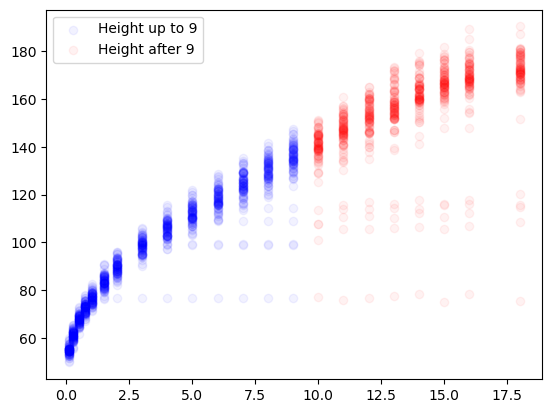

In [538]:
plt.scatter(
    x="AgeGr",
    y="SHgt_cm",
    data=gen2_test,
    color="b",
    alpha=0.05,
    label="Height up to 9",
)
plt.scatter(
    x="age",
    y="height",
    data=melted_df,
    color="r",
    alpha=0.05,
    label="Height after 9",
)
plt.legend()

In [539]:
melted_df[melted_df['child_id'] == 2831]

,child_id,age,height
0,2831,10,139.170029
1,2831,11,146.357742
2,2831,12,153.089828
3,2831,13,156.215546
4,2831,14,161.927475
5,2831,15,166.876770
6,2831,16,168.638870
7,2831,18,166.977615


In [540]:
submission_df = pd.DataFrame(columns=['gen2id_age', 'SHgt_cm'])

submission_df['gen2id_age'] = melted_df['child_id'].astype(str) + '_' + melted_df['age'].astype(str)
submission_df['SHgt_cm'] = melted_df['height']

In [541]:
template = pd.read_csv("gen2_test_solution_template.csv")
template.head()

,gen2id_age,SHgt_cm
0,2831_10,150
1,2831_11,150
2,2831_12,150
3,2831_13,150
4,2831_14,150


In [554]:
submission_df_final = submission_df[submission_df['gen2id_age'].isin(template['gen2id_age'].values)]

In [558]:
len(submission_df_final)

589